In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used

In [2]:
import torch
import fastai
# from fastai import ImageList
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
#from sklearn.model_selection import KFold
from utiles.radam import *
from utiles.csvlogger import *
from utiles.mishactivation import *
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score,confusion_matrix
import warnings
warnings.filterwarnings("ignore")
fastai.__version__

'1.0.61'

In [3]:
# remove this cell if run locally
!mkdir './cache'
!mkdir './cache/torch'
!mkdir './cache/torch/checkpoints'
torch.hub.DEFAULT_CACHE_DIR = 'cache'

mkdir: cannot create directory ‘./cache’: File exists
mkdir: cannot create directory ‘./cache/torch’: File exists
mkdir: cannot create directory ‘./cache/torch/checkpoints’: File exists


In [4]:
sz = 128
bs = 32
nfolds = 2
SEED = 2020
N = 12 # number of tiles per image
TRAIN = './input/panda-16x128x128-tiles-data/train/'
LABELS = './input/prostate-cancer-grade-assessment/train.csv'

In [5]:
df = pd.read_csv(LABELS).set_index('image_id') ## read in "train.csv" and set 'image_id' as index column
files = sorted(set([p[:32] for p in os.listdir(TRAIN)])) ## extract image id from the img patch folder
df = df.loc[files]
df = df.reset_index() ## remove 'image_id' that without masks
## stratified KFold class that can preserve the sample percentatage in each fold. 
splits = StratifiedKFold(n_splits=nfolds, random_state=SEED, shuffle=True) 
splits = list(splits.split(df,df.isup_grade)) ## list[(fold1_train_idx, fold1_test_idx), (fold2_train_idx, fold2_test_idx), ...]

## mark each sample to the fold, in which the sample serve as a test case
folds_splits = np.zeros(len(df)).astype(np.int) ## [0, 0, ...] with the number of cases
for i in range(nfolds): 
    folds_splits[splits[i][1]] = i

df['split'] = folds_splits ## add the K fold assignment column
df.head(10)

,image_id,data_provider,isup_grade,gleason_score,split
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,0
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,0
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,0
5,002a4db09dad406c85505a00fb6f6144,karolinska,0,0+0,1
6,003046e27c8ead3e3db155780dc5498e,karolinska,1,3+3,0
7,0032bfa835ce0f43a92ae0bbab6871cb,karolinska,1,3+3,0
8,003a91841da04a5a31f808fb5c21538a,karolinska,1,3+3,0
9,003d4dd6bd61221ebc0bfb9350db333f,karolinska,1,3+3,1


Since I use zero padding and background corresponds to 255, I invert images as 255-img when load them. Therefore, the mean value is computed as '1 - mean'.

In [6]:
mean = torch.tensor([1.0-0.90949707, 1.0-0.8188697, 1.0-0.87795304])
std = torch.tensor([0.36357649, 0.49984502, 0.40477625])

In [7]:
def open_image(fn:PathOrStr, div:bool=True, convert_mode:str='RGB', cls:type=Image,
        after_open:Callable=None)->Image:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        x = PIL.Image.open(fn).convert(convert_mode)
    if after_open: x = after_open(x)
    x = pil2tensor(x,np.float32)
    if div: x.div_(255)
    return cls(1.0-x) #invert image for zero padding

class MImage(ItemBase):
    def __init__(self, imgs):
        self.obj, self.data = \
          (imgs), [(imgs[i].data - mean[...,None,None])/std[...,None,None] for i in range(len(imgs))]
    
    def apply_tfms(self, tfms,*args, **kwargs):
        for i in range(len(self.obj)):
            self.obj[i] = self.obj[i].apply_tfms(tfms, *args, **kwargs)
            self.data[i] = (self.obj[i].data - mean[...,None,None])/std[...,None,None]
        return self
    
    def __repr__(self): return f'{self.__class__.__name__} {img.shape for img in self.obj}'
    def to_one(self):
        img = torch.stack(self.data,1)
        img = img.view(3,-1,N,sz,sz).permute(0,1,3,2,4).contiguous().view(3,-1,sz*N)
        return Image(1.0 - (mean[...,None,None]+img*std[...,None,None]))

class MImageItemList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def __len__(self)->int: return len(self.items) or 1 
    
    def get(self, i):
        fn = Path(self.items[i])
        fnames = [Path(str(fn)+'_'+str(i)+'.png')for i in range(N)]
        imgs = [open_image(fname, convert_mode=self.convert_mode, after_open=self.after_open)
               for fname in fnames]
        return MImage(imgs)

    def reconstruct(self, t):
        return MImage([mean[...,None,None]+_t*std[...,None,None] for _t in t])
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(300,50), **kwargs):
        rows = min(len(xs),8)
        fig, axs = plt.subplots(rows,1,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()
        

#collate function to combine multiple images into one tensor
def MImage_collate(batch:ItemsList)->Tensor:
    result = torch.utils.data.dataloader.default_collate(to_data(batch))
    if isinstance(result[0],list):
        result = [torch.stack(result[0],1),result[1]]
    return result

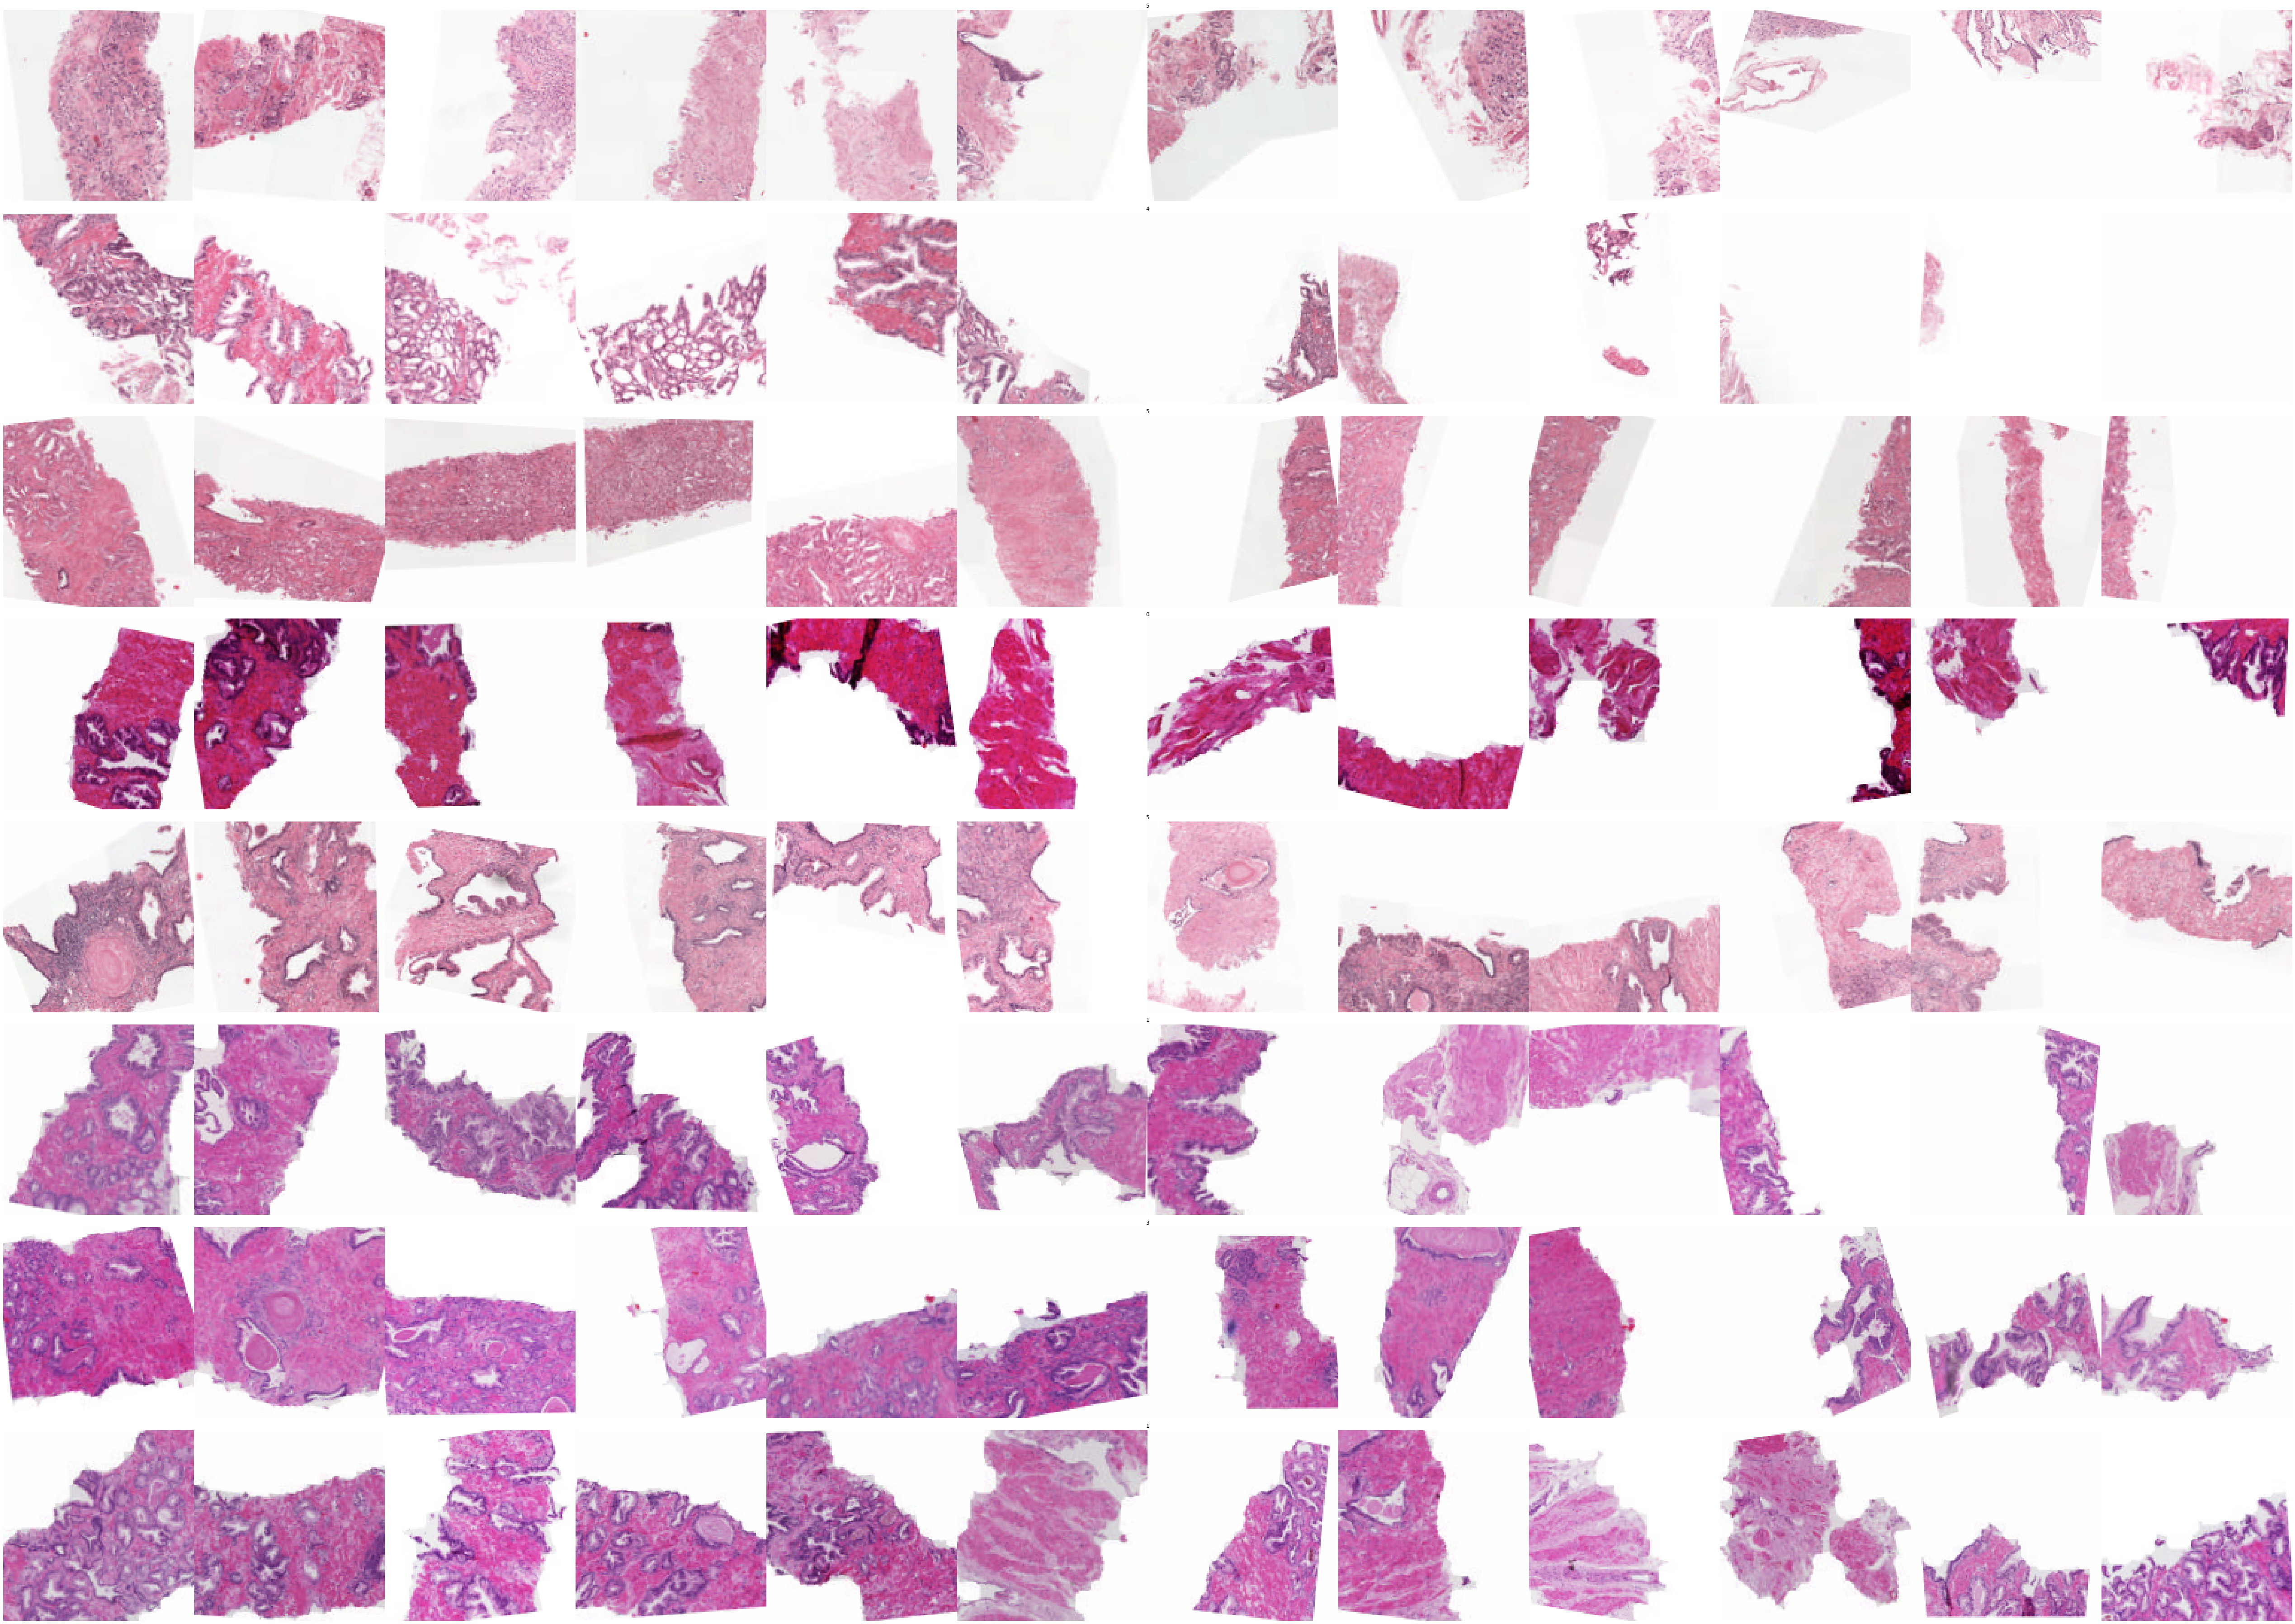

In [8]:
def get_data(fold=0):
    result = MImageItemList.from_df(df, path='.', folder=TRAIN, cols='image_id') ## create a MImageItemList from pandas df
    result = result.split_by_idx(df.index[df.split == fold].tolist()) ## split the data to train and val
    result = result.label_from_df(cols=['isup_grade']) ## add label to the data
    result = result.transform(get_transforms(flip_vert=True,max_rotate=15),size=sz,padding_mode='zeros') ## add transformation
    ## flip_vert: limit the flips to horizontal flips (when False) or to horizontal and vertical flips as well as 90-degrees rotations (when True)
    ## max_rotate: if not None, a random rotation between -max_rotate and max_rotate degrees is applied with probability p_affine (0/75)
    result = result.databunch(bs=bs,num_workers=4) ## batch the data
    return result

data = get_data(0)
data.show_batch()

In [9]:
class Model(nn.Module):
    def __init__(self, arch='resnext50_32x4d_ssl', n=6, pre=True):
        super().__init__()
        m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', arch)
        self.enc = nn.Sequential(*list(m.children())[:-2])       
        nc = list(m.children())[-1].in_features
        self.head = nn.Sequential(AdaptiveConcatPool2d(),Flatten(),nn.Linear(2*nc,512),
                            Mish(),nn.BatchNorm1d(512), nn.Dropout(0.5),nn.Linear(512,n))
        
    def forward(self, *x):
        shape = x[0].shape
        n = len(x)
        x = torch.stack(x,1).view(-1,shape[1],shape[2],shape[3])
        #x: bs*N x 3 x 128 x 128
        x = self.enc(x)
        #x: bs*N x C x 4 x 4
        shape = x.shape
        #concatenate the output for tiles into a single map
        x = x.view(-1,n,shape[1],shape[2],shape[3]).permute(0,2,1,3,4).contiguous()\
          .view(-1,shape[1],shape[2]*n,shape[3])
        #x: bs x C x N*4 x 4
        x = self.head(x)
        #x: bs x n
        return x

In [10]:
fname = 'RNXT50'
pred,target = [],[]
for fold in range(nfolds):
    data = get_data(fold)
    model = Model()
    learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), opt_func=Over9000, 
                metrics=[KappaScore(weights='quadratic')]).to_fp16()
    logger = CSVLogger(learn, f'log_{fname}_{fold}')
    learn.clip_grad = 1.0
    learn.split([model.head])
    learn.unfreeze()
#     print(f'{fname}_{fold}.pth')
    learn.fit_one_cycle(16, max_lr=1e-3, div_factor=100, pct_start=0.0)
#       callbacks = [SaveModelCallback(learn,name=f'model',monitor='kappa_score')])
    torch.save(learn.model.state_dict(), f'{fname}_{fold}.pth')
    
    learn.model.eval()
    with torch.no_grad():
        for step, (x, y) in progress_bar(enumerate(data.dl(DatasetType.Valid)),
                                     total=len(data.dl(DatasetType.Valid))):
            p = learn.model(*x)
            pred.append(p.float().cpu())
            target.append(y.cpu())

Downloading: "https://github.com/facebookresearch/semi-supervised-ImageNet1K-models/archive/master.zip" to cache/torch/hub/master.zip
Downloading: "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_supervised_resnext50_32x4-ddb3e555.pth" to cache/torch/checkpoints/semi_supervised_resnext50_32x4-ddb3e555.pth
100%|██████████| 100428550/100428550 [00:08<00:00, 11741484.15it/s]


epoch,train_loss,valid_loss,kappa_score,time


RuntimeError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 7.93 GiB total capacity; 6.87 GiB already allocated; 22.12 MiB free; 47.63 MiB cached)

In [ ]:
p = torch.argmax(torch.cat(pred,0),1)
t = torch.cat(target)
print(cohen_kappa_score(t,p,weights='quadratic'))
print(confusion_matrix(t,p))